In [1]:
"""
Temporary train script for quick-start training
"""
%load_ext autoreload
%autoreload 2

import os
from typing import Callable, Mapping

from mujoco_playground._src import mjx_env, wrapper
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # visible GPU masks
xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"

import functools
import json
from datetime import datetime

import jax
import jax.numpy as jp
import matplotlib.pyplot as plt
import mediapy as media
import mujoco
import wandb
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo

from IPython.display import clear_output, display


from vnl_mjx.tasks.rodent import head_track_rear, imitation
from vnl_mjx.tasks.rodent import wrappers

from omegaconf import OmegaConf

from tqdm import tqdm


from track_mjx.agent import checkpointing
from track_mjx.agent import wandb_logging
from track_mjx.agent.mlp_ppo import ppo_networks as track_networks

# Enable persistent compilation cache.
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [2]:
env_cfg = imitation.default_config()
env = wrappers.FlattenObsWrapper(imitation.Imitation(config=env_cfg))


In [3]:
env.observation_size, env.non_proprioceptive_obs_size, env.proprioceptive_obs_size, env.non_flattened_observation_size

(Array(866., dtype=float32),
 Array(640., dtype=float32),
 Array(226., dtype=float32),
 OrderedDict([('proprioception',
               OrderedDict([('joint_angles', Array(67, dtype=int32)),
                            ('joint_ang_vels', Array(67, dtype=int32)),
                            ('actuator_ctrl', Array(73, dtype=int32)),
                            ('body_height', Array(1., dtype=float32)),
                            ('world_zaxis', Array(3, dtype=int32)),
                            ('appendages_pos',
                             OrderedDict([('lower_arm_R',
                                           Array(3, dtype=int32)),
                                          ('lower_arm_L',
                                           Array(3, dtype=int32)),
                                          ('foot_R', Array(3, dtype=int32)),
                                          ('foot_L', Array(3, dtype=int32)),
                                          ('skull',
                         

In [ ]:
env_cfg = head_track_rear.default_config()
env = wrappers.FlattenObsWrapper(head_track_rear.HeadTrackRear(config=env_cfg))


In [2]:
mimic_checkpoint_path = (
    "/n/holylabs-olveczky/Users/charleszhang/track-mjx/model_checkpoints/250913_162327_167947"
)
mimic_cfg = OmegaConf.create(
    checkpointing.load_config_from_checkpoint(mimic_checkpoint_path)
)

In [3]:
decoder_policy_fn = track_networks.make_decoder_policy_fn(mimic_checkpoint_path)


In [4]:
env_cfg.reward_terms["head_z_dist"]["weight"] = 0.0
env_cfg.reward_terms["torso_z_range"]["weight"] = 0.0

env = head_track_rear.HeadTrackRear(config=env_cfg)
env = wrappers.HighLevelWrapper(
    wrappers.FlattenObsWrapper(env), 
    decoder_policy_fn, 
    mimic_cfg.network_config.intention_size,
    0, # the head track task has no non-proprioceptive obs
)


In [5]:
reset = jax.jit(env.reset)
step = jax.jit(env.step)

In [6]:
state = reset(rng=jax.random.PRNGKey(0))
states = [state]
print(f"Starting physics steps")
for i in tqdm(range(200)):
    state = step(state, jp.zeros(env.action_size))
    states.append(state)

Starting physics steps


100%|██████████| 200/200 [01:41<00:00,  1.97it/s]


To test that the hold_head_z reward is working correctly, I will manually raise qpos[2] by 0.15 - env._get_head_xpos()[2] (when the threshold is 0.12) and see if i get exactly 1 reward from that (after setting the head_z_dist weight to 0.0)

If that works, then the next thing is to test if i can continue to get reward if i do that multiple times (set it lower, then higher again for 50 steps (1 second))

In [22]:
from mujoco import mjx
forward = jax.jit(mjx.forward)

@jax.jit
def fix_qpos_z(state):
    # new_qpos = state.data.qpos.at[2].set(state.data.qpos[2] + jp.abs(0.2 - env._get_head_xpos(state.data)[2]))
    new_qpos = state.data.qpos.at[2].set(0.3)
    # also maintain the quaternion
    new_qpos = new_qpos.at[3:7].set(jp.array([1,0,0,0]))
    # also maintain joint angles as zero
    new_qpos = new_qpos.at[7:].set(jp.zeros(env._mjx_model.nq - 7))
    # return state.replace(data=state.data.replace(qpos=new_qpos))
    new_data = forward(env._mjx_model, state.data.replace(qpos=new_qpos))
    return state.replace(data=new_data)

In [27]:
state = reset(rng=jax.random.PRNGKey(0))
print(f"initial root z: {state.data.qpos[2]}")
print(f"initial head z: {env._get_head_xpos(state.data)[2]}")

initial root z: 0.05000000074505806
initial head z: 0.11524651944637299


In [23]:
print(f"Setting initial qpos to get head above z threshold")
state = reset(rng=jax.random.PRNGKey(0))
states = [fix_qpos_z(state)]
print(f"Starting physics steps")
for i in tqdm(range(200)):
    state = step(state, jp.zeros(env.action_size))
    # print(f"before fix: {env._get_head_xpos(state.data)[2]}")
    state = fix_qpos_z(state)
    # print(f"after fix: {env._get_head_xpos(state.data)[2]}")
    states.append(state)


Setting initial qpos to get head above z threshold
Starting physics steps


100%|██████████| 200/200 [00:12<00:00, 15.78it/s]


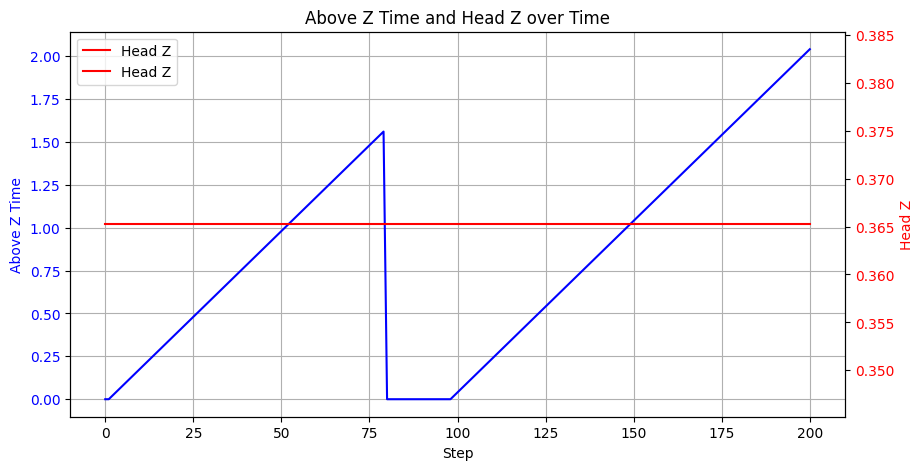

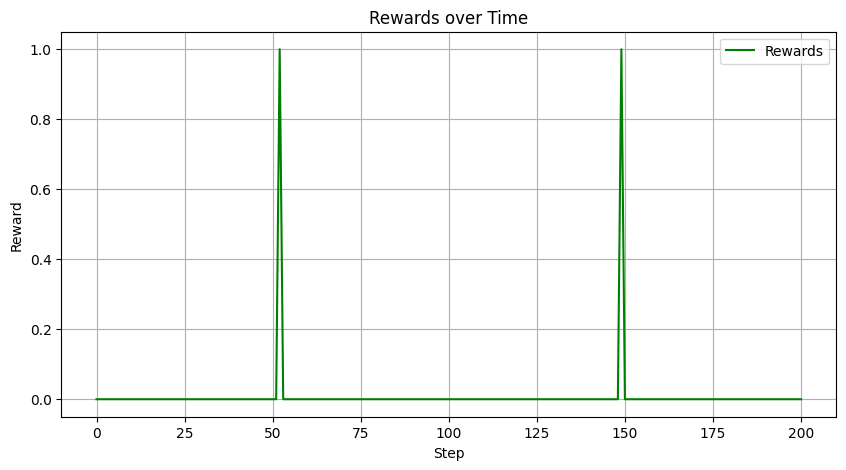

In [24]:
import matplotlib.pyplot as plt

rewards = [state.reward for state in states]
above_z_time = [state.info["above_z_time"] for state in states]
head_z = [env._get_head_xpos(state.data)[2] for state in states]

# First plot: Above Z Time and Head Z
plt.figure(figsize=(10, 5))
plt.plot(above_z_time, 'b-', label='Above Z Time')
plt.xlabel('Step')
plt.ylabel('Above Z Time', color='b')
plt.tick_params(axis='y', labelcolor='b')
plt.grid(True)

# Create second y-axis for head_z
ax2 = plt.gca().twinx()
ax2.plot(head_z, 'r-', label='Head Z')
ax2.set_ylabel('Head Z', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and legend for first plot
plt.title('Above Z Time and Head Z over Time')
lines1, labels1 = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.gca().legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.show()

# Second plot: Rewards over time
plt.figure(figsize=(10, 5))
plt.plot(rewards, 'g-', label='Rewards')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Rewards over Time')
plt.grid(True)
plt.legend()
plt.show()

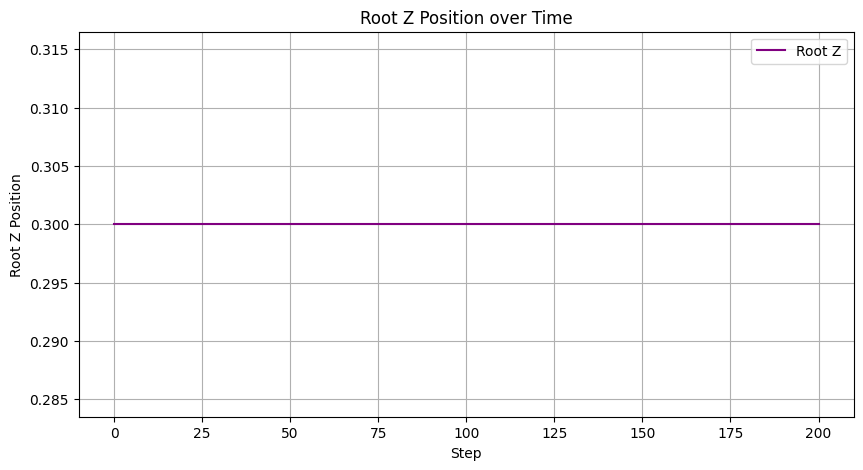

In [25]:
root_z = [state.data.qpos[2] for state in states]
plt.figure(figsize=(10, 5))
plt.plot(root_z, 'purple', label='Root Z')
plt.xlabel('Step')
plt.ylabel('Root Z Position')
plt.title('Root Z Position over Time')
plt.grid(True)
plt.legend()
plt.show()


In [10]:
qposes_rollout = [state.data.qpos for state in states]
import numpy as np
np.save("qposes_rollout.npy", qposes_rollout)


In [11]:
import imageio

mj_model = env._mj_model
mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model, height=512, width=512)
with imageio.get_writer("test_rollout.mp4", fps=int((1.0 / env.dt))) as video:
    for qpos in qposes_rollout:
        mj_data.qpos = qpos
        mujoco.mj_forward(mj_model, mj_data)
        renderer.update_scene(
            mj_data,
            camera="close_profile-rodent",
        )
        video.append_data(renderer.render())
        
media.show_video("test_rollout.mp4")

FatalError: gladLoadGL error